### スクレイピングからDBに格納

In [1]:
import requests
import sqlite3
import pandas as pd

def get_full_csv_url():
    relative_path = "/stat-search/file-download?statInfId=000040232700&fileKind=1"
    base_url = "https://www.e-stat.go.jp"
    return base_url + relative_path

def download_csv(csv_url, save_path="data.csv"):
    response = requests.get(csv_url)
    response.raise_for_status()
    with open(save_path, 'wb') as f:
        f.write(response.content)
    print(f"CSV downloaded to {save_path}")

def clean_column_names(df):
    # 列名を変更してSQLiteに適した形式にする
    cleaned_columns = {col: f"column_{i}" for i, col in enumerate(df.columns)}
    df = df.rename(columns=cleaned_columns)
    return df, cleaned_columns

def store_in_db(csv_path, db_name="data.db"):
    # エンコーディングを確認
    encoding = "shift_jis"  # 必要に応じて変更
    df = pd.read_csv(csv_path, encoding=encoding, header=0)  # ヘッダー行がある場合
    df.columns = df.columns.str.strip()  # 列名の空白を削除
    print(f"Original Columns in CSV: {df.columns}")

    # 列名をクリーンアップ
    df, column_map = clean_column_names(df)
    print(f"Cleaned Columns: {df.columns}")
    print(f"Column mapping: {column_map}")

    # データベースに保存
    conn = sqlite3.connect(db_name)
    df.to_sql("traffic_data", conn, if_exists="replace", index=False)
    conn.close()
    print(f"Data stored in {db_name}")
    return column_map

def read_from_db(db_name="data.db", column_map=None):
    conn = sqlite3.connect(db_name)

    # テーブルの構造を確認
    cursor = conn.execute("PRAGMA table_info(traffic_data)")
    columns = [row[1] for row in cursor.fetchall()]
    print(f"Columns in the table: {columns}")

    # クエリを実行
    if column_map:
        original_column = list(column_map.keys())[0]  # 元の列名
        cleaned_column = column_map[original_column]  # 変更後の列名
        query = f"SELECT {cleaned_column}, COUNT(*) AS count FROM traffic_data GROUP BY {cleaned_column}"
    else:
        query = f"SELECT {columns[0]}, COUNT(*) AS count FROM traffic_data GROUP BY {columns[0]}"
    
    df = pd.read_sql_query(query, conn)
    print(df.head())
    conn.close()

if __name__ == "__main__":
    try:
        csv_url = get_full_csv_url()
        download_csv(csv_url)
        column_map = store_in_db("data.csv")
        read_from_db(column_map=column_map)
        print("Process completed successfully.")
    except Exception as e:
        print(f"An error occurred: {e}")


CSV downloaded to data.csv
Original Columns in CSV: Index(['表2-16　昼夜別・年齢層別死者数の推移', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3',
       'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8',
       'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', '（各年11月末）'],
      dtype='object')
Cleaned Columns: Index(['column_0', 'column_1', 'column_2', 'column_3', 'column_4', 'column_5',
       'column_6', 'column_7', 'column_8', 'column_9', 'column_10',
       'column_11', 'column_12', 'column_13', 'column_14', 'column_15',
       'column_16'],
      dtype='object')
Column mapping: {'表2-16\u3000昼夜別・年齢層別死者数の推移': 'column_0', 'Unnamed: 1': 'column_1', 'Unnamed: 2': 'column_2', 'Unnamed: 3': 'column_3', 'Unnamed: 4': 'column_4', 'Unnamed: 5': 'column_5', 'Unnamed: 6': 'column_6', 'Unnamed: 7': 'column_7', 'Unnamed: 8': 'column_8', 'Unnamed: 9': 'column_9', 'Unnamed: 10': 'column_10', 'Unnamed: 11': 'column_11', 'Unnamed: 12': 'co

### 下処理

In [3]:
# データベースからデータを読み込む
conn = sqlite3.connect("data.db")
df = pd.read_sql_query("SELECT * FROM traffic_data", conn)
conn.close()

# 'column_0' に有効な値だけをフィルタリング
valid_data = df[df['column_0'].isin(['昼間', '夜間'])]
print(valid_data)


   column_0 column_1 column_2 column_3 column_4 column_5 column_6 column_7  \
5        昼間    4歳以下       16       22       20       12       15       17    
6        昼間   5〜9歳        26       26       18       21       15       11    
7        昼間   10〜14歳      16        7       10        6       14        4    
8        昼間   15〜19歳      51       44       45       36       53       30    
9        昼間   20〜24歳      51       58       69       68       61       55    
10       昼間   25〜29歳      47       46       45       46       37       32    
11       昼間   30〜34歳      51       40       48       46       41       35    
12       昼間   35〜39歳      53       68       67       43       38       39    
13       昼間   40〜44歳      71       68       81       66       58       38    
14       昼間   45〜49歳      84       65       75       99       88       68    
15       昼間   50〜54歳      80       87       78       80       87       82    
16       昼間   55〜59歳     103       96       89       87       83

### 棒グラフ

You should consider upgrading via the '/Users/murakamimasamiki/.pyenv/versions/3.10.1/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


/var/folders/gw/wg_9xbw97g9f88xl9q98tpkm0000gn/T/ipykernel_65949/4122911027.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['count'] = valid_data.iloc[:, 2:].sum(axis=1)
/Users/murakamimasamiki/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27515 (\N{CJK UNIFIED IDEOGRAPH-6B7B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/murakamimasamiki/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32773 (\N{CJK UNIFIED IDEOGRAPH-8005}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/murakamimasamiki/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/cor

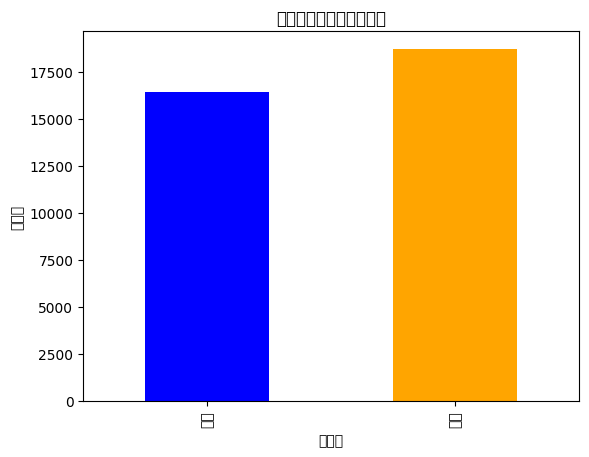

In [4]:
%pip install matplotlib
import matplotlib.pyplot as plt

# 数値型に変換してから 'count'列を作成
valid_data.iloc[:, 2:] = valid_data.iloc[:, 2:].apply(pd.to_numeric, errors='coerce')
valid_data['count'] = valid_data.iloc[:, 2:].sum(axis=1)

# 昼夜のデータを集計
day_night_summary = valid_data.groupby('column_0')['count'].sum()

# 棒グラフを作成
day_night_summary.plot(kind='bar', color=['blue', 'orange'])
plt.title('昼間と夜間の死者数比較')
plt.xlabel('時間帯')
plt.ylabel('死者数')
plt.show()


### 年次推移の分析

/Users/murakamimasamiki/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27515 (\N{CJK UNIFIED IDEOGRAPH-6B7B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/murakamimasamiki/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32773 (\N{CJK UNIFIED IDEOGRAPH-8005}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/murakamimasamiki/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/murakamimasamiki/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/murakamimasamiki/.pyenv/v

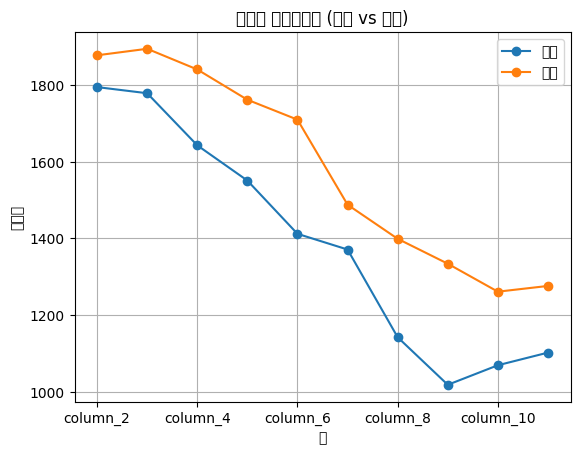

In [6]:
# 年次データを抽出
year_columns = [f"column_{i}" for i in range(2, 12)]  # 年次列のリスト
yearly_data = valid_data[["column_0"] + year_columns]

# 昼夜別に年次データを集計
yearly_summary = yearly_data.groupby("column_0").sum().T

# 年次データをプロット
yearly_summary.plot(kind='line', marker='o')
plt.title('年次別 死者数推移 (昼間 vs 夜間)')
plt.xlabel('年')
plt.ylabel('死者数')
plt.legend(['昼間', '夜間'])
plt.grid()
plt.show()


### ヒートマップで昼夜と年齢層の分析

You should consider upgrading via the '/Users/murakamimasamiki/.pyenv/versions/3.10.1/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


/Users/murakamimasamiki/.pyenv/versions/3.10.1/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 12316 (\N{WAVE DASH}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/murakamimasamiki/.pyenv/versions/3.10.1/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 27507 (\N{CJK UNIFIED IDEOGRAPH-6B73}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/murakamimasamiki/.pyenv/versions/3.10.1/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 20197 (\N{CJK UNIFIED IDEOGRAPH-4EE5}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/murakamimasamiki/.pyenv/versions/3.10.1/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 19979 (\N{CJK UNIFIED IDEOGRAPH-4E0B}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/murakamimasamiki/.pyenv/versions/3.10.1/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from font(s) DejaV

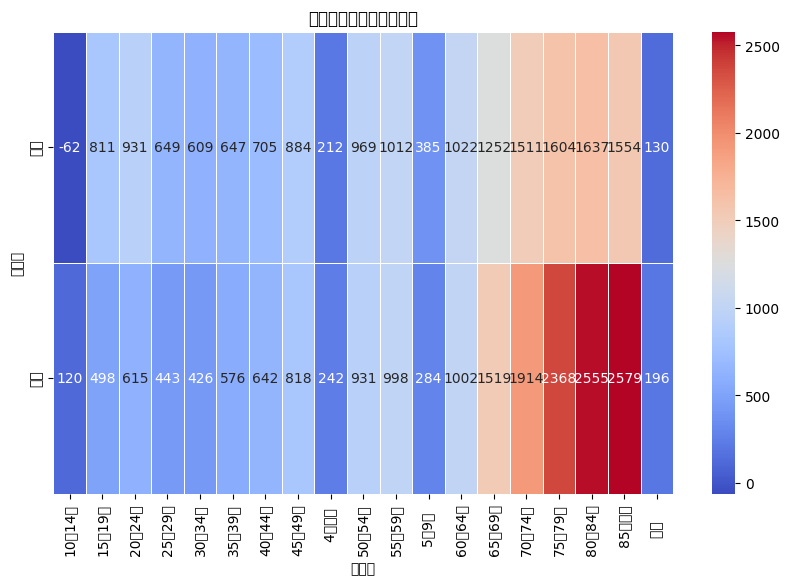

In [7]:
%pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# 年齢層ごとの昼夜別死者数のデータを抽出
heatmap_data = valid_data.pivot_table(index="column_0", columns="column_1", values="count", aggfunc="sum")

# データを数値型に変換
heatmap_data = heatmap_data.apply(pd.to_numeric, errors='coerce')

# ヒートマップのプロット
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="coolwarm", linewidths=.5)
plt.title("昼夜別・年齢層別死者数")
plt.xlabel("年齢層")
plt.ylabel("時間帯")
plt.show()


### 昼夜別の割合を円グラフで表示

/var/folders/gw/wg_9xbw97g9f88xl9q98tpkm0000gn/T/ipykernel_65949/2562235665.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  day_night_ratio.plot(kind='pie', autopct="%.1f%%", labels=["昼間", "夜間"], colors=["skyblue", "orange"])
/Users/murakamimasamiki/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26172 (\N{CJK UNIFIED IDEOGRAPH-663C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/murakamimasamiki/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22812 (\N{CJK UNIFIED IDEOGRAPH-591C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/murakamimasamiki/.pyenv/versions/3.10.1/lib/python3.10/site

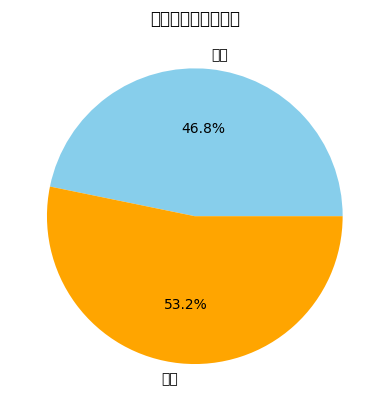

In [8]:
# 昼夜別の割合を計算
day_night_ratio = valid_data.groupby('column_0')['count'].sum()

# 円グラフをプロット
day_night_ratio.plot(kind='pie', autopct="%.1f%%", labels=["昼間", "夜間"], colors=["skyblue", "orange"])
plt.title("昼夜別の死者数割合")
plt.ylabel("")  # Y軸ラベルを非表示
plt.show()


###  昼夜・年次別の傾向をスタックバープロットで表示

/Users/murakamimasamiki/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27515 (\N{CJK UNIFIED IDEOGRAPH-6B7B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/murakamimasamiki/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32773 (\N{CJK UNIFIED IDEOGRAPH-8005}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/murakamimasamiki/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/murakamimasamiki/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26172 (\N{CJK UNIFIED IDEOGRAPH-663C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/murakamimasamiki/.pyenv/v

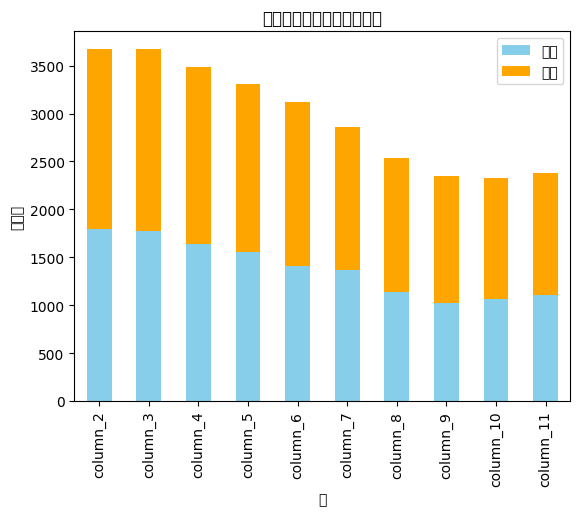

In [9]:
# 年次データを抽出
yearly_data = valid_data[["column_0"] + year_columns]

# 年次ごとの昼夜データを集計
stacked_summary = yearly_data.groupby("column_0").sum()

# 積み上げ棒グラフをプロット
stacked_summary.T.plot(kind='bar', stacked=True, color=["skyblue", "orange"])
plt.title("昼夜別の年次死者数の推移")
plt.xlabel("年")
plt.ylabel("死者数")
plt.legend(["昼間", "夜間"])
plt.show()


### 年齢層ごとの死者数分布をボックスプロットで表示

/var/folders/gw/wg_9xbw97g9f88xl9q98tpkm0000gn/T/ipykernel_65949/1528783891.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="column_1", y="count", data=valid_data, palette="coolwarm")
/Users/murakamimasamiki/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27515 (\N{CJK UNIFIED IDEOGRAPH-6B7B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/murakamimasamiki/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32773 (\N{CJK UNIFIED IDEOGRAPH-8005}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/murakamimasamiki/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing f

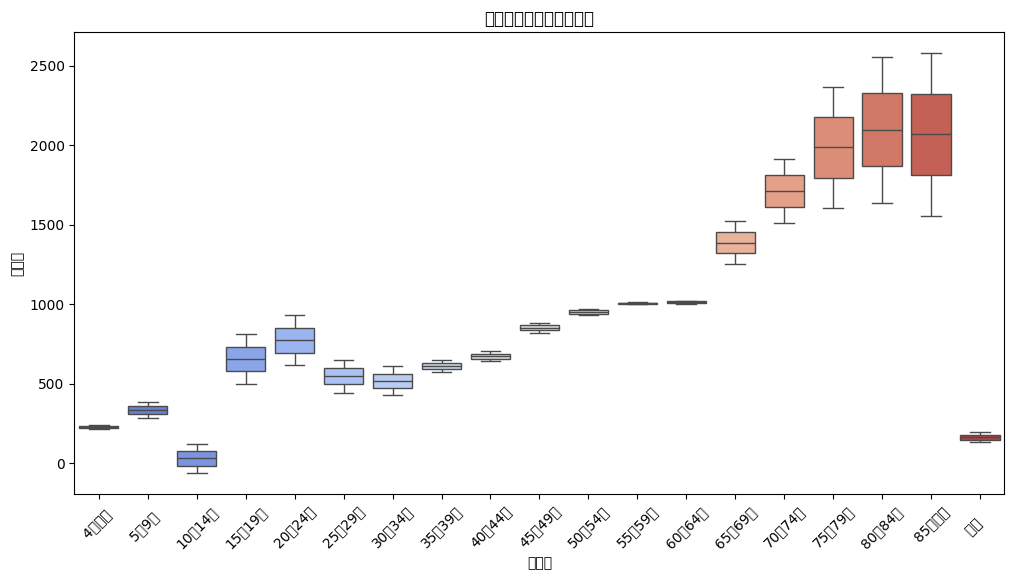

In [13]:
# 年齢層と死者数のボックスプロット
plt.figure(figsize=(12, 6))
sns.boxplot(x="column_1", y="count", data=valid_data, palette="coolwarm")
plt.title("年齢層ごとの死者数分布")
plt.xlabel("年齢層")
plt.ylabel("死者数")
plt.xticks(rotation=45)
plt.show()


###  昼夜別の年齢層の死者数割合をスタックエリアグラフで表示

/Users/murakamimasamiki/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27515 (\N{CJK UNIFIED IDEOGRAPH-6B7B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/murakamimasamiki/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32773 (\N{CJK UNIFIED IDEOGRAPH-8005}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/murakamimasamiki/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/murakamimasamiki/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26172 (\N{CJK UNIFIED IDEOGRAPH-663C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/murakamimasamiki/.pyenv/v

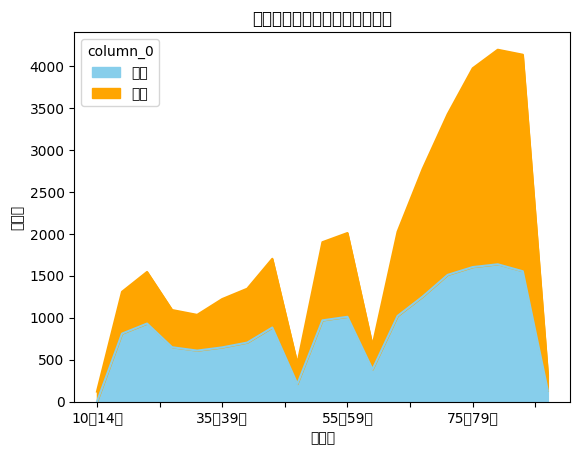

In [12]:
# 年齢層と昼夜別の割合データを計算
area_data = valid_data.groupby(["column_1", "column_0"])["count"].sum().unstack()

# Replace negative values with zero
area_data[area_data < 0] = 0

# スタックエリアグラフのプロット
area_data.plot(kind="area", stacked=True, color=["skyblue", "orange"])
plt.title("昼夜別・年齢層別の死者数割合")
plt.xlabel("年齢層")
plt.ylabel("死者数")
plt.show()
